<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #11: Twitter
`Fecha de entrega: Mayo 20, 2021 (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

###  `[25 pts]` Punto 1: Extraer Tuits
Extraer mínimo 100 tuits de Twitter usando la API

❌ No escoger un tema de los que hicimos en clase (día de las madres, Giro de Italia, #EraGoldeYepes)

In [25]:
import os
import pandas as pd
import json
import tweepy
import re 
import regex
import emoji
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

import scipy.cluster.hierarchy as sch
import numpy as np

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [27]:

# Obtener variables de entorno desde sistema local
API_KEY = os.getenv('TWITTER_API_KEY')
API_SECRET_KEY = os.environ.get('TWITTER_API_SECRET_KEY')
BEARER_TOKEN =os.environ.get('TWITTER_BEARER_TOKEN')
ACCESS_TOKEN= os.environ.get('TWITTER_ACCESS_TOKEN')
ACCESS_TOKEN_SECRET= os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')


auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

tweets = tweepy.Cursor(api.search,
                       q=['Matarife -RT'],
                       lang='es',
                       geocode='4.3646,-74.0414,100km',
                       tweet_mode='extended',
                       include_rts=False,
                       ).items(110)

# Objeto generador
t = [tweet for tweet in tweets]

t_processed = []

for tweet in t: 
    temp = []
    temp.append(tweet.full_text)
    temp.append(tweet.created_at)
    temp.append('Bogotá')
    temp.append(tweet.user.location)
    temp.append(tweet.id)
    temp.append(f"https://twitter.com/i/web/stuatus/{tweet.id}")
    
    t_processed.append(temp)
   
datos = pd.DataFrame(t_processed)
datos.columns = ['tweets', 'fecha', 'ciudad', 'localizacion_usuario', 'id', 'enlace']
datos.head()


,tweets,fecha,ciudad,localizacion_usuario,id,enlace
0,@PrimeraLineacol El paró no lo para nadie hast...,2021-05-19 17:59:02,Bogotá,"Bogotá, D.C., Colombia",1395076547103510530,https://twitter.com/i/web/stuatus/139507654710...
1,"@intiasprilla joven, cumplido los 18, vote en ...",2021-05-19 17:54:54,Bogotá,Bogotá,1395075505326596096,https://twitter.com/i/web/stuatus/139507550532...
2,Y entonces el #Matarife y sus secuaces pretend...,2021-05-19 17:49:49,Bogotá,"Bogotá, D.C., Colombia",1395074226118438916,https://twitter.com/i/web/stuatus/139507422611...
3,@AlvaroUribeVel A LAS QUE EL GOBIERNO NO AYUDA...,2021-05-19 17:46:44,Bogotá,Bogota Colombia,1395073452244152325,https://twitter.com/i/web/stuatus/139507345224...
4,"@petrogustavo Muy bien, pero cuídate mucho, tú...",2021-05-19 17:45:44,Bogotá,"Bogotá, D.C., Colombia",1395073199059124228,https://twitter.com/i/web/stuatus/139507319905...


In [28]:
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'

def text_clean(row):
    text = row['tweets']
    
    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")
    
    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag, "")
        
    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention, "")
        
    return text, links, hashtags, mentions
  
  
datos[['texto_limpio', 'enlaces', 'hashtags', 'menciones']] = datos.apply(text_clean, axis=1, result_type='expand')
datos.head()

,tweets,fecha,ciudad,localizacion_usuario,id,enlace,texto_limpio,enlaces,hashtags,menciones
0,@PrimeraLineacol El paró no lo para nadie hast...,2021-05-19 17:59:02,Bogotá,"Bogotá, D.C., Colombia",1395076547103510530,https://twitter.com/i/web/stuatus/139507654710...,El paró no lo para nadie hasta lograr liberta...,[],[],[@PrimeraLineacol]
1,"@intiasprilla joven, cumplido los 18, vote en ...",2021-05-19 17:54:54,Bogotá,Bogotá,1395075505326596096,https://twitter.com/i/web/stuatus/139507550532...,"joven, cumplido los 18, vote en el 2006 por e...",[],[],"[@intiasprilla, @AlvaroUribeVel,]"
2,Y entonces el #Matarife y sus secuaces pretend...,2021-05-19 17:49:49,Bogotá,"Bogotá, D.C., Colombia",1395074226118438916,https://twitter.com/i/web/stuatus/139507422611...,Y entonces el y sus secuaces pretenden arrodi...,[https://t.co/r39ROk5yYX],"[#Matarife, #UribeGolpista, #YoApoyoAQuintero]",[]
3,@AlvaroUribeVel A LAS QUE EL GOBIERNO NO AYUDA...,2021-05-19 17:46:44,Bogotá,Bogota Colombia,1395073452244152325,https://twitter.com/i/web/stuatus/139507345224...,A LAS QUE EL GOBIERNO NO AYUDA PORQUE SOLO HA...,[],[],[@AlvaroUribeVel]
4,"@petrogustavo Muy bien, pero cuídate mucho, tú...",2021-05-19 17:45:44,Bogotá,"Bogotá, D.C., Colombia",1395073199059124228,https://twitter.com/i/web/stuatus/139507319905...,"Muy bien, pero cuídate mucho, tú sabes que ha...",[],[],[@petrogustavo]


In [4]:
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list
  
  

datos['emojis'] = datos['texto_limpio'].apply(lambda text: get_emojis(text))
datos.head()

,tweets,fecha,ciudad,localizacion_usuario,id,enlace,texto_limpio,enlaces,hashtags,menciones,emojis
0,@natiibedoya 1- el es su presidente no mio\n2...,2021-05-19 05:00:08,Bogotá,"Bogotá, D.C., Colombia",1394880528097153028,https://twitter.com/i/web/stuatus/139488052809...,1- el es su presidente no mio\n2- yo no voté...,[],[],[@natiibedoya],[]
1,@AlvaroUribeVel Un mensaje de Diomedez para el...,2021-05-19 04:43:16,Bogotá,"Bogotá, D.C., Colombia",1394876284208046081,https://twitter.com/i/web/stuatus/139487628420...,Un mensaje de Diomedez para el personaje que ...,[https://t.co/SIPI99RoJT],[],[@AlvaroUribeVel],[]
2,"Esta perla que me encontré del Matarife, el de...",2021-05-19 04:21:50,Bogotá,Bogotá-Colombia,1394870890370945028,https://twitter.com/i/web/stuatus/139487089037...,"Esta perla que me encontré del Matarife, el de...",[https://t.co/MgQQHJt0IA],[],[],[]
3,"@jerojasrodrigue @CIDH Viejo ridiculo, la orde...",2021-05-19 04:14:18,Bogotá,"Bogotá, Colombia",1394868994532839424,https://twitter.com/i/web/stuatus/139486899453...,"Viejo ridiculo, la orden de Álvaro es que ma...",[],[],"[@jerojasrodrigue, @CIDH]",[]
4,@intiasprilla El Matarife en su primer periodo...,2021-05-19 04:11:29,Bogotá,Bogotá-Colombia,1394868287490646016,https://twitter.com/i/web/stuatus/139486828749...,"El Matarife en su primer periodo, por lo cual...",[],[],[@intiasprilla],[]


###  `[25 pts]` Punto 2: Hacer una visualización sobre esos tuits

* Se realizaron dos gráficas relacionadas con los tweets recuperados, a saber: 
    Agrupaciones de tweets con el método k-means y tweets por hora (gráfico visto en clase).
    

In [37]:
# Definición de función de pre-procesamiento
stopwords_sp = stopwords.words('spanish')
stopwords_sp.extend(["https", "http", "co", "com", "edu","eu","Álvaro","Uribe", "Vélez", "Matarife", "u","û","q","k","w","a","p","pg","b","c","f","z","j",
                  "v","n","g","e","r","x","l","h","st","rt","lol","aa", "vélez","vélezel","álvaro","uribe"])

def preProcesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split() # Tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

In [38]:
tfidf_vect = TfidfVectorizer(preprocessor=preProcesado)
tfidf = tfidf_vect.fit_transform(datos.texto_limpio.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())
tfidf_matrix

,abogado,abogánster,abuso,acaba,acabar,acaso,aceptar,acepte,activos,actualizando,...,voto,votó,voz,vuelta,vándalos,ximena,zapateiro,órdenes,último,único
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.216679,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


env: OMP_NUM_THREADS=8


D:\ProgramFiles\Anaconda3.2020.11\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



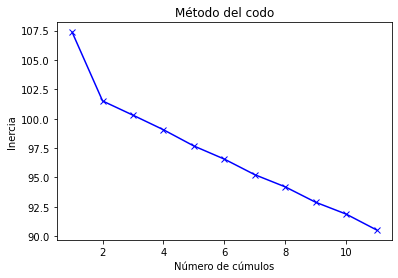

In [39]:
%set_env OMP_NUM_THREADS=8
ks = []
k_inertias = []

for k in range(1,12):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)
    
    
# list(zip(ks,k_inertias))

plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-');

In [40]:
k = 3
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

datos['cluster'] = model.labels_
datos

,tweets,fecha,ciudad,localizacion_usuario,id,enlace,texto_limpio,enlaces,hashtags,menciones,cluster
0,@PrimeraLineacol El paró no lo para nadie hast...,2021-05-19 17:59:02,Bogotá,"Bogotá, D.C., Colombia",1395076547103510530,https://twitter.com/i/web/stuatus/139507654710...,El paró no lo para nadie hasta lograr liberta...,[],[],[@PrimeraLineacol],0
1,"@intiasprilla joven, cumplido los 18, vote en ...",2021-05-19 17:54:54,Bogotá,Bogotá,1395075505326596096,https://twitter.com/i/web/stuatus/139507550532...,"joven, cumplido los 18, vote en el 2006 por e...",[],[],"[@intiasprilla, @AlvaroUribeVel,]",1
2,Y entonces el #Matarife y sus secuaces pretend...,2021-05-19 17:49:49,Bogotá,"Bogotá, D.C., Colombia",1395074226118438916,https://twitter.com/i/web/stuatus/139507422611...,Y entonces el y sus secuaces pretenden arrodi...,[https://t.co/r39ROk5yYX],"[#Matarife, #UribeGolpista, #YoApoyoAQuintero]",[],1
3,@AlvaroUribeVel A LAS QUE EL GOBIERNO NO AYUDA...,2021-05-19 17:46:44,Bogotá,Bogota Colombia,1395073452244152325,https://twitter.com/i/web/stuatus/139507345224...,A LAS QUE EL GOBIERNO NO AYUDA PORQUE SOLO HA...,[],[],[@AlvaroUribeVel],1
4,"@petrogustavo Muy bien, pero cuídate mucho, tú...",2021-05-19 17:45:44,Bogotá,"Bogotá, D.C., Colombia",1395073199059124228,https://twitter.com/i/web/stuatus/139507319905...,"Muy bien, pero cuídate mucho, tú sabes que ha...",[],[],[@petrogustavo],2
...,...,...,...,...,...,...,...,...,...,...,...
105,Minga reparte comida y #TalibánDuque bala: cad...,2021-05-19 13:17:05,Bogotá,Bogotá,1395005592092258305,https://twitter.com/i/web/stuatus/139500559209...,Minga reparte comida y bala: cada cual repart...,[],"[#TalibánDuque, #Matarife:, #RenuncieMolano, #...",[],1
106,Cuando tu educación limita tu imaginación se l...,2021-05-19 13:11:12,Bogotá,Bogotá,1395004108839473154,https://twitter.com/i/web/stuatus/139500410883...,Cuando tu educación limita tu imaginación se l...,[],"[#Quinterosequeda, #DDHH, #Reformajudicial, #R...","[@Nessnio, @dw_espanol, @AFPespanol]",1
107,@maromero86 @ClaudiaLopez Esto no es cierto vi...,2021-05-19 12:59:01,Bogotá,"Bogotá, D.C., Colombia",1395001044338450434,https://twitter.com/i/web/stuatus/139500104433...,Esto no es cierto viejo tampoco mentir favor...,[],[#Matarife],"[@maromero86, @ClaudiaLopez]",1
108,@joanpada7 @PizarroMariaJo Dios quiera que la ...,2021-05-19 12:56:15,Bogotá,"Guadalajara de Buga, Colombia",1395000348528480259,https://twitter.com/i/web/stuatus/139500034852...,Dios quiera que la dictadura nunca le afecte...,[],[],"[@joanpada7, @PizarroMariaJo]",1


In [41]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = datos['cluster'].value_counts()
clust_cnt_pct = datos['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in datos.iloc[nbrs.kneighbors([centroids[i]])[1][0]].texto_limpio.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("********************************************")
    print()

Cluster # 0
Tiene 7 registros (6.36% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
narcogobierno iván lograr libertar duque colombia paró nadie terrorista asesino matarife único diálogo sólo paracos paro paraco si genocida marchas 

DOCUMENTOS MÁS REPRESENTATIVOS
 ***  El paró no lo para nadie hasta lograr libertar Colombia de este narcogobierno asesino terrorista de Iván duque y el matarife Álvaro Uribe Vélez

 ***   El paró no lo para nadie hasta lograr libertar Colombia de este narcogobierno asesino terrorista de Iván duque y el matarife Álvaro Uribe Vélez Él paró no lo para nadie hasta lograr libertar Colombia de este narcogobierno asesino terrorista de Iván duque y el matarife uribe Vélez

 ***  Él paró no lo para nadie hasta lograr libertar Colombia de este narcogobierno asesino terrorista de Iván duque y el matarife Álvaro Uribe Vélez. El paró no lo para nadie hasta lograr libertar Colombia de este narcogobierno asesino terrorista de Iván duque y el matarife Uribe


**************

In [46]:
clusters = {0: "Cluster 0 - PARO", 
            1: "Cluster 1 - DICTADURA",
            2: "Cluster 2 - EXPROPIACIÓN",
            
}

datos['nombres_clusters'] = datos['cluster'].apply(lambda val: clusters[val])
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = datos.nombres_clusters.values
result['texto'] = datos.texto_limpio.apply(lambda val: val[:])

colorsIdx = {
            "Cluster 0 - PARO": "yellow", 
            "Cluster 1 - DICTADURA": "blue",
            "Cluster 2 - EXPROPIACIÓN": "red" }

result['colores'] = result['cluster'].map(colorsIdx)
result

,X,Y,cluster,texto,colores
0,0.923199,-0.001157,Cluster 0 - PARO,El paró no lo para nadie hasta lograr liberta...,yellow
1,-0.008495,0.034496,Cluster 1 - DICTADURA,"joven, cumplido los 18, vote en el 2006 por e...",blue
2,-0.082540,-0.196800,Cluster 1 - DICTADURA,Y entonces el y sus secuaces pretenden arrodi...,blue
3,-0.078775,0.063560,Cluster 1 - DICTADURA,A LAS QUE EL GOBIERNO NO AYUDA PORQUE SOLO HA...,blue
4,-0.065701,-0.044651,Cluster 2 - EXPROPIACIÓN,"Muy bien, pero cuídate mucho, tú sabes que ha...",red
...,...,...,...,...,...
105,-0.070324,-0.050476,Cluster 1 - DICTADURA,Minga reparte comida y bala: cada cual repart...,blue
106,-0.068617,-0.037295,Cluster 1 - DICTADURA,Cuando tu educación limita tu imaginación se l...,blue
107,-0.078050,-0.088855,Cluster 1 - DICTADURA,Esto no es cierto viejo tampoco mentir favor...,blue
108,-0.075458,-0.003565,Cluster 1 - DICTADURA,Dios quiera que la dictadura nunca le afecte...,blue


### Gráfico de agrupaciones de Tweets:

In [47]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="KMEANS- TWEETS")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

In [22]:
datos['hora'] = datos['fecha'].dt.floor('T').dt.time

In [23]:
conteos = pd.DataFrame(datos.hora.value_counts()).reset_index()
conteos.columns = ['hora', 'cuenta']
conteos = conteos.sort_values('hora')
conteos

,hora,cuenta
63,00:03:00,1
6,00:05:00,2
83,00:14:00,1
31,00:23:00,1
17,00:25:00,1
...,...,...
18,23:42:00,1
58,23:49:00,1
15,23:50:00,1
24,23:56:00,1


### Gráfico de tweets por hora

In [10]:

trace = go.Scatter(x=conteos.hora.values,
                   y=conteos.cuenta.values,
                   text=[f"Fecha: {f}<br>Tuits: {c}" for f,c in zip(conteos.hora.values,conteos.cuenta.values)],
                   hoverinfo='text',
                   mode='lines+markers',
                   name='Horas',
                   line={'color': 'blue'})

layout = go.Layout(title="Número de tuits por hora")

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)